In [1]:
# ---- Parameters ----
SCREEN = "20241118_AWALS35_intermediate_screen_n72"

In [2]:
# Parameters
SCREEN = "20250216_AWALS37_Full_screen_n96"


In [3]:
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import importlib
import sys
import pandas as pd
from pathlib import Path

sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/20250916_pipelines/params")
with open(pdir / "binary-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir / "binary-split-test.json", "r") as f:
    test_params = json.load(f)

train_params["screen"] = SCREEN
test_params["screen"] = SCREEN

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["FUS/EEA1"]
response_map = {"WT": 0, "FUS": 1}

In [4]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

assert train_screen.data is not None, "Loading failed"
assert test_screen.data is not None, "Loading failed"

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...


Preprocessing complete
Processing test set...


Preprocessing complete
Marker set: FUS/EEA1
Train data: (24907, 315)
Test data: (22728, 315)


In [5]:
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig()
dataloader_config.batch_size = 8
dataloader_config.n_cells = 250
dataloader_config.response_map = {"Mutations": response_map}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=train_dataloader._get_scalers(),
    **vars(dataloader_config)
)

In [6]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3
train_config.use_contrastive_loss = True

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

model_test = MultiAntibodyClassifier(**vars(model_config))
test_dataloader.mode = "train"
train(model_test, test_dataloader, train_config)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.7597, Active: 1/1
  FUS/EEA1 - Loss: 0.8016, Acc: 0.4928 


Cell Epoch 2/100, Overall Loss: 2.4744, Active: 1/1
  FUS/EEA1 - Loss: 0.6783, Acc: 0.5948 


Cell Epoch 3/100, Overall Loss: 2.3879, Active: 1/1
  FUS/EEA1 - Loss: 0.6642, Acc: 0.6098 


Cell Epoch 4/100, Overall Loss: 2.2768, Active: 1/1
  FUS/EEA1 - Loss: 0.6069, Acc: 0.6753 


Cell Epoch 5/100, Overall Loss: 2.2310, Active: 1/1
  FUS/EEA1 - Loss: 0.6008, Acc: 0.6893 


Cell Epoch 6/100, Overall Loss: 2.1851, Active: 1/1
  FUS/EEA1 - Loss: 0.5990, Acc: 0.6815 


Cell Epoch 7/100, Overall Loss: 2.1173, Active: 1/1
  FUS/EEA1 - Loss: 0.5773, Acc: 0.6970 


Cell Epoch 8/100, Overall Loss: 2.1224, Active: 1/1
  FUS/EEA1 - Loss: 0.5689, Acc: 0.7140 


Cell Epoch 9/100, Overall Loss: 2.0675, Active: 1/1
  FUS/EEA1 - Loss: 0.5849, Acc: 0.6930 


Cell Epoch 10/100, Overall Loss: 2.0220, Active: 1/1
  FUS/EEA1 - Loss: 0.5736, Acc: 0.7018 


Cell Epoch 11/100, Overall Loss: 2.0603, Active: 1/1
  FUS/EEA1 - Loss: 0.6009, Acc: 0.6950 


Cell Epoch 12/100, Overall Loss: 2.0308, Active: 1/1
  FUS/EEA1 - Loss: 0.6120, Acc: 0.6705 


Cell Epoch 13/100, Overall Loss: 2.0126, Active: 1/1
  FUS/EEA1 - Loss: 0.5588, Acc: 0.7150 


Cell Epoch 14/100, Overall Loss: 1.9515, Active: 1/1
  FUS/EEA1 - Loss: 0.5720, Acc: 0.7078 


Cell Epoch 15/100, Overall Loss: 1.9951, Active: 1/1
  FUS/EEA1 - Loss: 0.5737, Acc: 0.7045 


Cell Epoch 16/100, Overall Loss: 1.9747, Active: 1/1
  FUS/EEA1 - Loss: 0.5721, Acc: 0.7013 


Cell Epoch 17/100, Overall Loss: 2.0066, Active: 1/1
  FUS/EEA1 - Loss: 0.5789, Acc: 0.7075 


Cell Epoch 18/100, Overall Loss: 1.9991, Active: 1/1
  FUS/EEA1 - Loss: 0.6324, Acc: 0.6545 


Cell Epoch 19/100, Overall Loss: 1.9312, Active: 1/1
  FUS/EEA1 - Loss: 0.5475, Acc: 0.7478 


Cell Epoch 20/100, Overall Loss: 1.8711, Active: 1/1
  FUS/EEA1 - Loss: 0.5575, Acc: 0.7188 


Cell Epoch 21/100, Overall Loss: 1.9026, Active: 1/1
  FUS/EEA1 - Loss: 0.5688, Acc: 0.7128 


Cell Epoch 22/100, Overall Loss: 1.8871, Active: 1/1
  FUS/EEA1 - Loss: 0.5644, Acc: 0.7090 


Cell Epoch 23/100, Overall Loss: 1.8496, Active: 1/1
  FUS/EEA1 - Loss: 0.5392, Acc: 0.7410 


Cell Epoch 24/100, Overall Loss: 1.8433, Active: 1/1
  FUS/EEA1 - Loss: 0.5680, Acc: 0.7155 


Cell Epoch 25/100, Overall Loss: 1.9335, Active: 1/1
  FUS/EEA1 - Loss: 0.6131, Acc: 0.6710 


Cell Epoch 26/100, Overall Loss: 1.8524, Active: 1/1
  FUS/EEA1 - Loss: 0.5366, Acc: 0.7410 


Cell Epoch 27/100, Overall Loss: 1.8208, Active: 1/1
  FUS/EEA1 - Loss: 0.5516, Acc: 0.7220 


Cell Epoch 28/100, Overall Loss: 1.8710, Active: 1/1
  FUS/EEA1 - Loss: 0.5686, Acc: 0.7063 


Cell Epoch 29/100, Overall Loss: 1.8558, Active: 1/1
  FUS/EEA1 - Loss: 0.5456, Acc: 0.7425 


Cell Epoch 30/100, Overall Loss: 1.8146, Active: 1/1
  FUS/EEA1 - Loss: 0.5435, Acc: 0.7375 


Cell Epoch 31/100, Overall Loss: 1.8467, Active: 1/1
  FUS/EEA1 - Loss: 0.5464, Acc: 0.7375 


Cell Epoch 32/100, Overall Loss: 1.7528, Active: 1/1
  FUS/EEA1 - Loss: 0.5202, Acc: 0.7443 


Cell Epoch 33/100, Overall Loss: 1.7448, Active: 1/1
  FUS/EEA1 - Loss: 0.5330, Acc: 0.7423 


Cell Epoch 34/100, Overall Loss: 1.8207, Active: 1/1
  FUS/EEA1 - Loss: 0.5704, Acc: 0.7055 


Cell Epoch 35/100, Overall Loss: 1.8343, Active: 1/1
  FUS/EEA1 - Loss: 0.5757, Acc: 0.6973 


Cell Epoch 36/100, Overall Loss: 1.8786, Active: 1/1
  FUS/EEA1 - Loss: 0.5425, Acc: 0.7340 


Cell Epoch 37/100, Overall Loss: 1.9779, Active: 1/1
  FUS/EEA1 - Loss: 0.6541, Acc: 0.6333 


Cell Epoch 38/100, Overall Loss: 1.8964, Active: 1/1
  FUS/EEA1 - Loss: 0.6720, Acc: 0.6123 


Cell Epoch 39/100, Overall Loss: 1.9006, Active: 1/1
  FUS/EEA1 - Loss: 0.5727, Acc: 0.7145 


Cell Epoch 40/100, Overall Loss: 1.8194, Active: 1/1
  FUS/EEA1 - Loss: 0.5330, Acc: 0.7463 


Cell Epoch 41/100, Overall Loss: 1.8091, Active: 1/1
  FUS/EEA1 - Loss: 0.5350, Acc: 0.7398 


  Freezing FUS/EEA1 encoder at epoch 42
Cell Epoch 42/100, Overall Loss: 1.7468, Active: 0/1
  FUS/EEA1 - Loss: 0.5269, Acc: 0.7448 [FROZEN]
All antibodies frozen - stopping cell training at epoch 42
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.7018


Line Epoch 2/100, Loss: 0.6173


Line Epoch 3/100, Loss: 0.6177


Line Epoch 4/100, Loss: 0.5981


Line Epoch 5/100, Loss: 0.5822


Line Epoch 6/100, Loss: 0.5494


Line Epoch 7/100, Loss: 0.5209


Line Epoch 8/100, Loss: 0.4512


Line Epoch 9/100, Loss: 0.4765


Line Epoch 10/100, Loss: 0.4551


Line Epoch 11/100, Loss: 0.4445


Line Epoch 12/100, Loss: 0.3691


Line Epoch 13/100, Loss: 0.4208


Line Epoch 14/100, Loss: 0.3845


Line Epoch 15/100, Loss: 0.4244


Line Epoch 16/100, Loss: 0.3786


Line Epoch 17/100, Loss: 0.3955


Line Epoch 18/100, Loss: 0.4167


Line Epoch 19/100, Loss: 0.4650


Line Epoch 20/100, Loss: 0.3181


Line Epoch 21/100, Loss: 0.3320


Line Epoch 22/100, Loss: 0.4616


Line Epoch 23/100, Loss: 0.3959


Line Epoch 24/100, Loss: 0.3652


Line Epoch 25/100, Loss: 0.3421


Line Epoch 26/100, Loss: 0.3026


Line Epoch 27/100, Loss: 0.3488


Line Epoch 28/100, Loss: 0.3691


Line Epoch 29/100, Loss: 0.3847


Line Epoch 30/100, Loss: 0.3165


Line Epoch 31/100, Loss: 0.3044


Line Epoch 32/100, Loss: 0.3479


Line Epoch 33/100, Loss: 0.3948


Line Epoch 34/100, Loss: 0.4225


Line Epoch 35/100, Loss: 0.4804


Line Epoch 36/100, Loss: 0.3148
Early stopping line training at epoch 36
Training completed!
Evaluating model...


Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.7775, Active: 1/1
  FUS/EEA1 - Loss: 0.7444, Acc: 0.5060 


Cell Epoch 2/100, Overall Loss: 2.5921, Active: 1/1
  FUS/EEA1 - Loss: 0.6691, Acc: 0.5960 


Cell Epoch 3/100, Overall Loss: 2.5088, Active: 1/1
  FUS/EEA1 - Loss: 0.6423, Acc: 0.6305 


Cell Epoch 4/100, Overall Loss: 2.3889, Active: 1/1
  FUS/EEA1 - Loss: 0.6038, Acc: 0.6778 


Cell Epoch 5/100, Overall Loss: 2.3151, Active: 1/1
  FUS/EEA1 - Loss: 0.5879, Acc: 0.6900 


Cell Epoch 6/100, Overall Loss: 2.2719, Active: 1/1
  FUS/EEA1 - Loss: 0.5660, Acc: 0.7155 


Cell Epoch 7/100, Overall Loss: 2.2543, Active: 1/1
  FUS/EEA1 - Loss: 0.5540, Acc: 0.7168 


Cell Epoch 8/100, Overall Loss: 2.3271, Active: 1/1
  FUS/EEA1 - Loss: 0.6534, Acc: 0.6433 


Cell Epoch 9/100, Overall Loss: 2.1817, Active: 1/1
  FUS/EEA1 - Loss: 0.5606, Acc: 0.7105 


Cell Epoch 10/100, Overall Loss: 2.1278, Active: 1/1
  FUS/EEA1 - Loss: 0.5539, Acc: 0.7178 


Cell Epoch 11/100, Overall Loss: 2.2004, Active: 1/1
  FUS/EEA1 - Loss: 0.5967, Acc: 0.6868 


Cell Epoch 12/100, Overall Loss: 2.1523, Active: 1/1
  FUS/EEA1 - Loss: 0.5678, Acc: 0.7050 


Cell Epoch 13/100, Overall Loss: 2.0550, Active: 1/1
  FUS/EEA1 - Loss: 0.5569, Acc: 0.7268 


Cell Epoch 14/100, Overall Loss: 2.0193, Active: 1/1
  FUS/EEA1 - Loss: 0.5394, Acc: 0.7288 


Cell Epoch 15/100, Overall Loss: 2.0546, Active: 1/1
  FUS/EEA1 - Loss: 0.6000, Acc: 0.6778 


Cell Epoch 16/100, Overall Loss: 2.0761, Active: 1/1
  FUS/EEA1 - Loss: 0.5568, Acc: 0.7295 


Cell Epoch 17/100, Overall Loss: 2.0400, Active: 1/1
  FUS/EEA1 - Loss: 0.5855, Acc: 0.6915 


Cell Epoch 18/100, Overall Loss: 2.1644, Active: 1/1
  FUS/EEA1 - Loss: 0.6597, Acc: 0.6368 


Cell Epoch 19/100, Overall Loss: 1.9961, Active: 1/1
  FUS/EEA1 - Loss: 0.5372, Acc: 0.7475 


Cell Epoch 20/100, Overall Loss: 2.0028, Active: 1/1
  FUS/EEA1 - Loss: 0.5453, Acc: 0.7338 


Cell Epoch 21/100, Overall Loss: 2.0167, Active: 1/1
  FUS/EEA1 - Loss: 0.5966, Acc: 0.6885 


Cell Epoch 22/100, Overall Loss: 1.9298, Active: 1/1
  FUS/EEA1 - Loss: 0.5274, Acc: 0.7483 


Cell Epoch 23/100, Overall Loss: 2.0557, Active: 1/1
  FUS/EEA1 - Loss: 0.6176, Acc: 0.6675 


Cell Epoch 24/100, Overall Loss: 2.0220, Active: 1/1
  FUS/EEA1 - Loss: 0.5659, Acc: 0.7140 


Cell Epoch 25/100, Overall Loss: 1.8935, Active: 1/1
  FUS/EEA1 - Loss: 0.5320, Acc: 0.7423 


Cell Epoch 26/100, Overall Loss: 1.9258, Active: 1/1
  FUS/EEA1 - Loss: 0.5461, Acc: 0.7325 


Cell Epoch 27/100, Overall Loss: 1.9934, Active: 1/1
  FUS/EEA1 - Loss: 0.5754, Acc: 0.6965 


Cell Epoch 28/100, Overall Loss: 1.9809, Active: 1/1
  FUS/EEA1 - Loss: 0.5548, Acc: 0.7155 


Cell Epoch 29/100, Overall Loss: 2.0501, Active: 1/1
  FUS/EEA1 - Loss: 0.6265, Acc: 0.6645 


Cell Epoch 30/100, Overall Loss: 1.9967, Active: 1/1
  FUS/EEA1 - Loss: 0.6037, Acc: 0.6833 


Cell Epoch 31/100, Overall Loss: 1.9055, Active: 1/1
  FUS/EEA1 - Loss: 0.5222, Acc: 0.7500 


Cell Epoch 32/100, Overall Loss: 1.9862, Active: 1/1
  FUS/EEA1 - Loss: 0.5566, Acc: 0.7138 


Cell Epoch 33/100, Overall Loss: 1.9266, Active: 1/1
  FUS/EEA1 - Loss: 0.5681, Acc: 0.7065 


Cell Epoch 34/100, Overall Loss: 1.8934, Active: 1/1
  FUS/EEA1 - Loss: 0.5279, Acc: 0.7400 


Cell Epoch 35/100, Overall Loss: 1.9096, Active: 1/1
  FUS/EEA1 - Loss: 0.5655, Acc: 0.7148 


Cell Epoch 36/100, Overall Loss: 1.9890, Active: 1/1
  FUS/EEA1 - Loss: 0.5635, Acc: 0.7173 


Cell Epoch 37/100, Overall Loss: 1.9226, Active: 1/1
  FUS/EEA1 - Loss: 0.5306, Acc: 0.7505 


Cell Epoch 38/100, Overall Loss: 1.9423, Active: 1/1
  FUS/EEA1 - Loss: 0.5680, Acc: 0.7123 


Cell Epoch 39/100, Overall Loss: 2.0459, Active: 1/1
  FUS/EEA1 - Loss: 0.6348, Acc: 0.6408 


Cell Epoch 40/100, Overall Loss: 1.8645, Active: 1/1
  FUS/EEA1 - Loss: 0.5122, Acc: 0.7615 


Cell Epoch 41/100, Overall Loss: 1.9716, Active: 1/1
  FUS/EEA1 - Loss: 0.6037, Acc: 0.6740 


Cell Epoch 42/100, Overall Loss: 1.9115, Active: 1/1
  FUS/EEA1 - Loss: 0.5301, Acc: 0.7483 


Cell Epoch 43/100, Overall Loss: 1.9124, Active: 1/1
  FUS/EEA1 - Loss: 0.5264, Acc: 0.7510 


Cell Epoch 44/100, Overall Loss: 2.0412, Active: 1/1
  FUS/EEA1 - Loss: 0.6433, Acc: 0.6548 


Cell Epoch 45/100, Overall Loss: 1.9931, Active: 1/1
  FUS/EEA1 - Loss: 0.5822, Acc: 0.6963 


Cell Epoch 46/100, Overall Loss: 1.9844, Active: 1/1
  FUS/EEA1 - Loss: 0.5861, Acc: 0.6958 


Cell Epoch 47/100, Overall Loss: 1.9269, Active: 1/1
  FUS/EEA1 - Loss: 0.5541, Acc: 0.7185 


Cell Epoch 48/100, Overall Loss: 2.0358, Active: 1/1
  FUS/EEA1 - Loss: 0.6456, Acc: 0.6395 


Cell Epoch 49/100, Overall Loss: 1.9138, Active: 1/1
  FUS/EEA1 - Loss: 0.5503, Acc: 0.7333 


  Freezing FUS/EEA1 encoder at epoch 50
Cell Epoch 50/100, Overall Loss: 1.9551, Active: 0/1
  FUS/EEA1 - Loss: 0.5964, Acc: 0.6900 [FROZEN]
All antibodies frozen - stopping cell training at epoch 50
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.6687


Line Epoch 2/100, Loss: 0.6281


Line Epoch 3/100, Loss: 0.5392


Line Epoch 4/100, Loss: 0.6638


Line Epoch 5/100, Loss: 0.5125


Line Epoch 6/100, Loss: 0.4336


Line Epoch 7/100, Loss: 0.5307


Line Epoch 8/100, Loss: 0.4636


Line Epoch 9/100, Loss: 0.4156


Line Epoch 10/100, Loss: 0.4338


Line Epoch 11/100, Loss: 0.3551


Line Epoch 12/100, Loss: 0.7676


Line Epoch 13/100, Loss: 0.3874


Line Epoch 14/100, Loss: 0.4143


Line Epoch 15/100, Loss: 0.4187


Line Epoch 16/100, Loss: 0.3704


Line Epoch 17/100, Loss: 0.3782


Line Epoch 18/100, Loss: 0.3914


Line Epoch 19/100, Loss: 0.4269


Line Epoch 20/100, Loss: 0.3710


Line Epoch 21/100, Loss: 0.4622
Early stopping line training at epoch 21
Training completed!
Evaluating model...


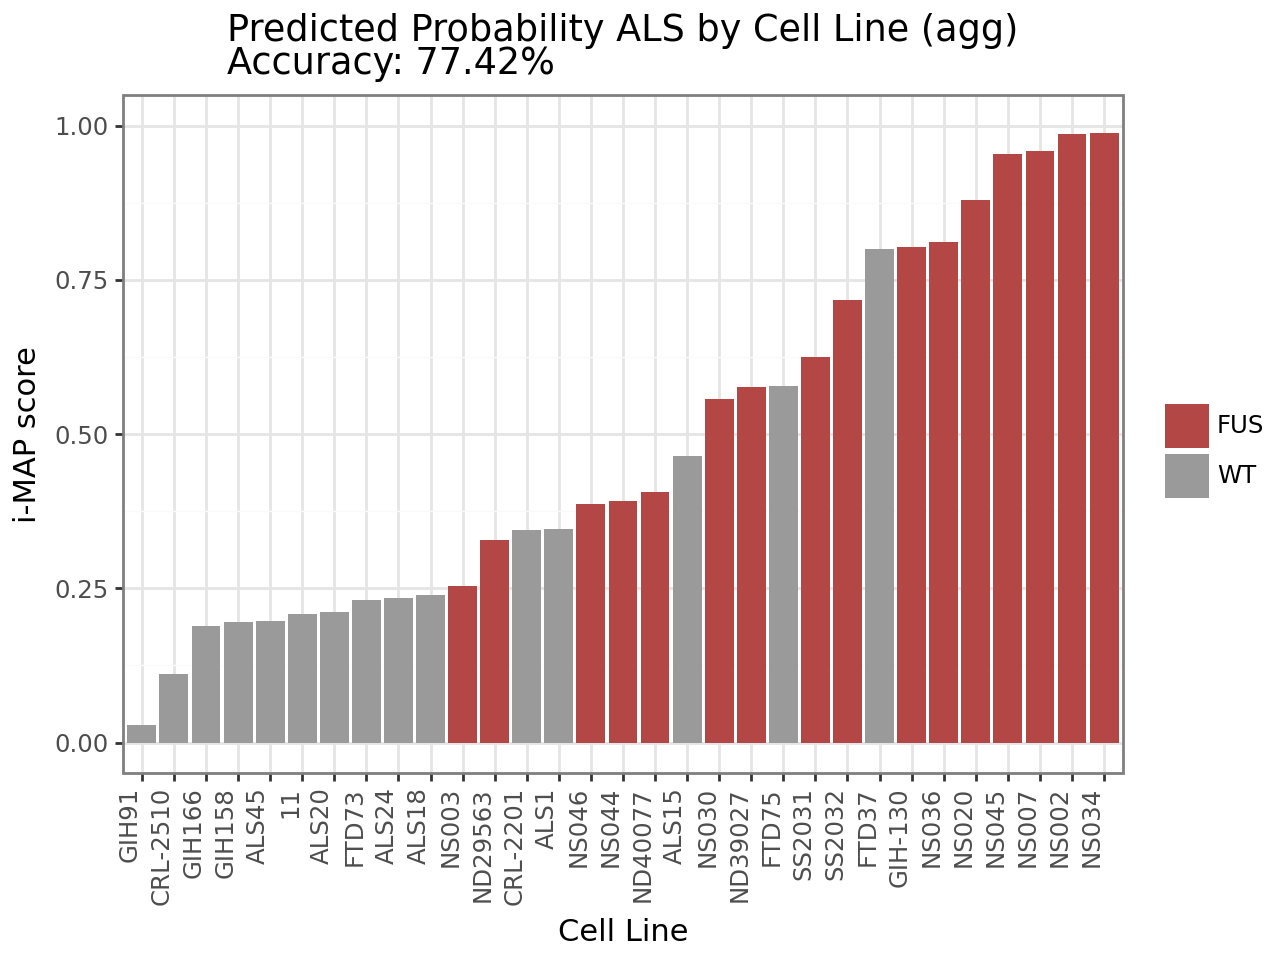

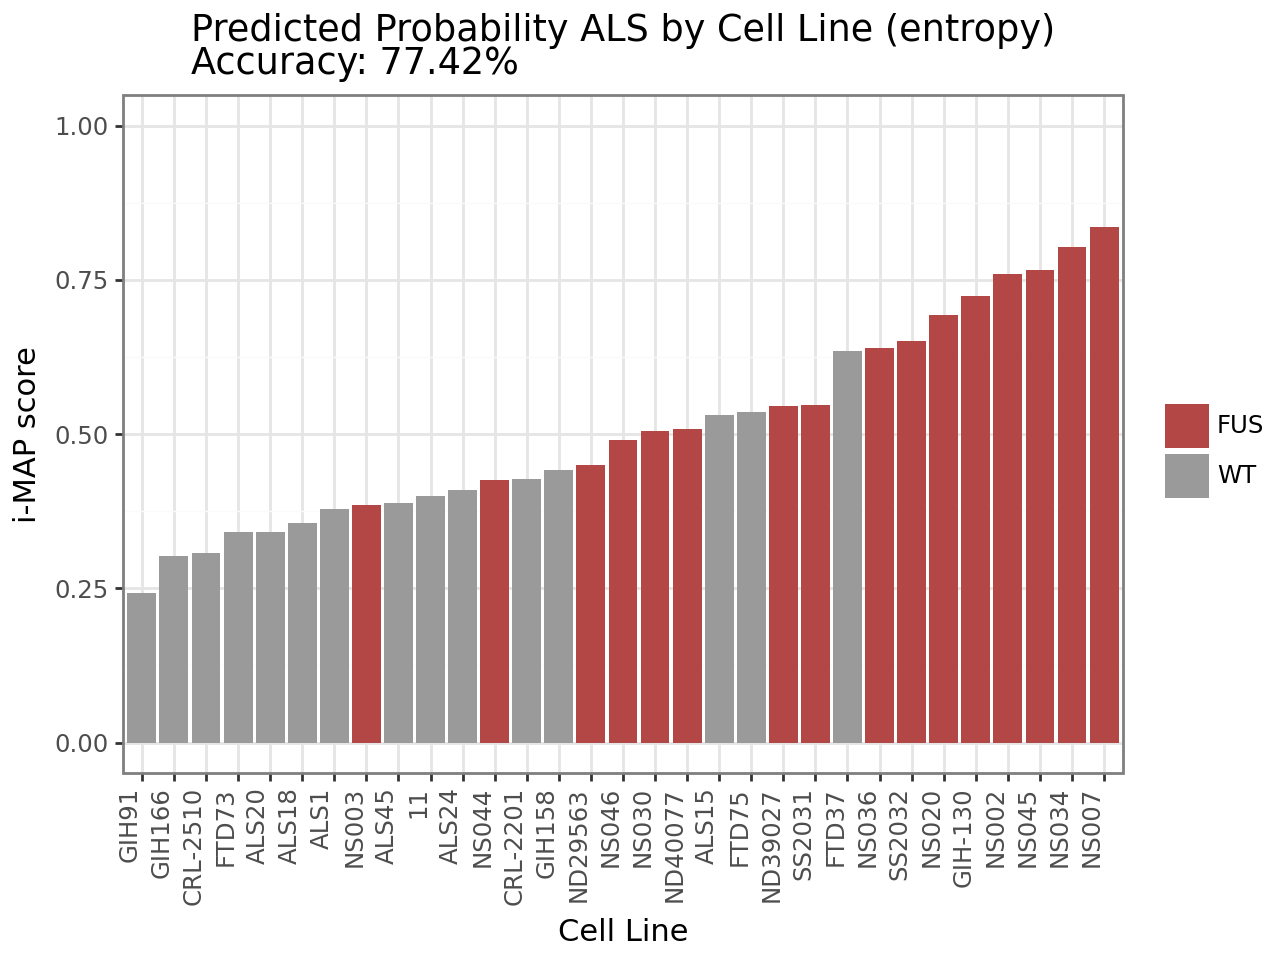

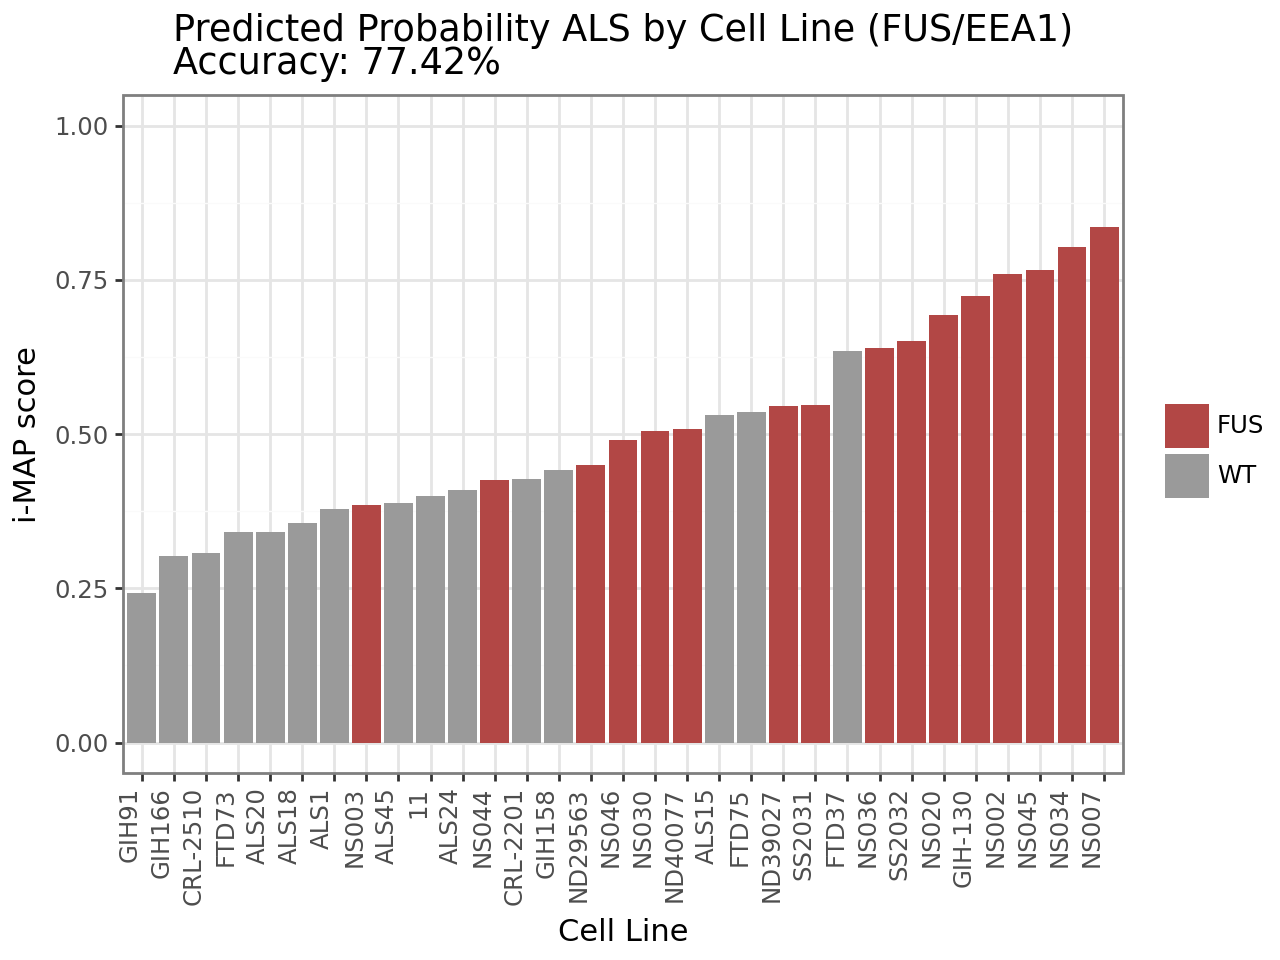

In [7]:
from IPython.display import display
from maps.figures import PALETTE

from plotnine import (
    ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
)

df = pd.concat([df_train, df_test])
groups = ["agg", "entropy"] + antibodies

def plot_preds(df, groups, response_map):
    for g in groups:
        # Sort preds by predicted probability (Class_1) in ascending order
        preds = df.sort_values(by=f'class_1_{g}', ascending=True)
        
        preds['CellLines'] = pd.Categorical(
            preds['CellLines'], categories=preds['CellLines'], ordered=True
        )
        
        # Compute prediction accuracy for current group
        pred_labels = (preds[f'class_1_{g}'] > 0.5)
        accuracy = (pred_labels == preds["True"]).mean()
        preds["True"] = preds["True"].map({0: "WT", 1: "FUS"})
        
        p = (
            ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
            geom_bar(stat='identity') +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=90, hjust=1)) +
            labs(x='Cell Line', y='i-MAP score', fill="") +
            ggtitle(
                f"Predicted Probability ALS by Cell Line ({g})\nAccuracy: {accuracy:.2%}") +
            scale_fill_manual(values=PALETTE) +
            ylim(0, 1)
        )
        display(p)
        
plot_preds(df, groups, response_map)

In [8]:

screen = train_params["screen"]
df["Mutation"] = df["True"].map({0: "WT", 1: "FUS"})
df = df.rename(columns={"True": "TrueClass"})
df = df.rename(columns={"class_0_agg":"prob_0", "class_1_agg":"prob_1"})
df = df[["prob_0", "prob_1", "CellLines", "TrueClass", "Mutation"]]

out_dir = Path("/home/kkumbier/als/analysis_results")
out_path = out_dir / SCREEN / f"fus_v_wt.csv"
df.to_csv(out_path, index=False)